### Setup

In [1]:
# Import libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import adjusted_mutual_info_score
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import communities as com
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_mutual_info_score
from networkx.algorithms.community.kclique import k_clique_communities
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
from ortools.linear_solver import pywraplp
from pyvis.network import Network
from scipy.spatial.distance import pdist, squareform
# Custom libraries
import utils as lu
import correlation_clustering as cc
# Reload modules in case of modifications
reload(lu)
reload(cc)

<module 'correlation_clustering' from '/home/louiscam/projects/gpcr/code/figures3/correlation_clustering.py'>

In [2]:
# Specify all directories

# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of processed HiC
dir_processed_hic = '/home/louiscam/projects/gpcr/save/processed_hic_data_dir/'
# Directory for storing preliminary results
prelim_results_dir = '/home/louiscam/projects/gpcr/save/prelim_results_dir/'
# Directory of epigenomic data
epigenome_dir = '/home/louiscam/projects/gpcr/data/epigenome_data/'
processed_epigenome_data_dir = '/home/louiscam/projects/gpcr/save/processed_epigenome_data_dir/'
# Directory of proteins of interest
dir_proteins = '/home/louiscam/projects/gpcr/data/protein_families/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'

In [3]:
# Relevant information
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'

# Load data

In [4]:
# Load gene location in hg19
gene_locations_filename = dir_genome+'chrom_hg19.loc_canonical'
gene_id_filename = dir_genome+'chrom_hg19.name'
df_loc = lu.get_all_gene_locations(gene_locations_filename, gene_id_filename)

In [5]:
# Adhesome genes and loci
active_adhesome_genes = pickle.load(open(saving_dir+'active_adhesome_genes.pkl', 'rb'))
active_adhesome_loci = pickle.load(open(saving_dir+'active_adhesome_genes_loci.pkl', 'rb'))
adhesome_chr_loci = pickle.load(open(saving_dir+'adhesome_chr_loci.pkl', 'rb'))

In [6]:
# Adhesome TF genes and loci
active_lung_adhesome_tf_genes = pickle.load(open(saving_dir+'active_lung_adhesome_tf_genes.pkl','rb'))
active_lung_adhesome_tf_loci = pickle.load(open(saving_dir+'active_lung_adhesome_tf_loci.pkl','rb'))

In [7]:
# All genes selected: Adhesome + TF + mechanoreg genes and loci
selected_genes = pickle.load(open(saving_dir+'joint_genes.pkl','rb'))
selected_loci = pickle.load(open(saving_dir+'joint_loci.pkl','rb'))
selected_gene2locus = pickle.load(open(saving_dir+'gene2locus.pkl','rb'))
selected_locus2gene = pickle.load(open(saving_dir+'locus2gene.pkl','rb'))
joint_chr_loci = pickle.load(open(saving_dir+'joint_chr_loci.pkl', 'rb'))
contacts_df = pickle.load(open(saving_dir+'contacts_df.pkl','rb')).loc[selected_loci,selected_loci]

In [46]:
# Load gene to chromosome dict
gene2chrom = pickle.load(open(saving_dir+'gene2chrom.pkl','rb'))
# Load hTFtarget data set
active_lung_tf2target = pickle.load(open(saving_dir+'active_lung_tf2target.pkl', 'rb'))
active_lung_target2tf = pickle.load(open(saving_dir+'active_lung_target2tf.pkl', 'rb'))
# All genes
all_active_genes = pickle.load(open(saving_dir+'all_active_genes.pkl', 'rb'))
# Metadata
active_lung_tf_genes = pickle.load(open(saving_dir+'active_lung_tf_genes.pkl','rb'))
proteins_df = pickle.load(open(dir_proteins+'mechanoreg_proteins.pkl', 'rb'))
collagens = proteins_df[proteins_df['family']=='collagen']['geneSymbol'].values
lamins = proteins_df[proteins_df['family']=='lamin']['geneSymbol'].values
lims = proteins_df[proteins_df['family']=='LIM']['geneSymbol'].values
mmps = proteins_df[proteins_df['family']=='MMP']['geneSymbol'].values
elastin = proteins_df[proteins_df['family']=='elastin']['geneSymbol'].values
fibronectin = proteins_df[proteins_df['family']=='fibronectin']['geneSymbol'].values
tenascins = proteins_df[proteins_df['family']=='tenascin']['geneSymbol'].values
other_genes = np.array(list(itertools.chain.from_iterable([collagens,lamins,lims,mmps,elastin,fibronectin,tenascins])))

# Network of adhesome genes and adhesome TF genes

### Network of adhesome genes: interX edges

### Network of adhesome genes: intraX edges

### Network of adhesome genes: interX and intraX

In [8]:
# Load edge lists
joint_interX_edge_list = pickle.load(open(saving_dir+'joint_interX_edge_list.pkl', 'rb'))
joint_intraX_edge_list = pickle.load(open(saving_dir+'joint_intraX_edge_list.pkl', 'rb'))

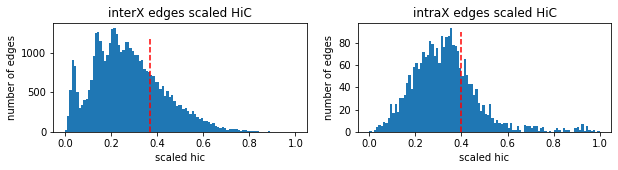

In [9]:
# Plot thresholds
plt.figure(figsize=(10,2))
plt.subplot(1, 2, 1)
plt.hist(joint_interX_edge_list['scaled_hic'], bins=np.arange(0,1.01,0.01))
plt.vlines(x=np.quantile(joint_interX_edge_list['scaled_hic'],0.75), ymin=0, ymax=1200, 
           color='red', linestyle='dashed')
plt.xlabel('scaled hic')
plt.ylabel('number of edges')
plt.title('interX edges scaled HiC')

plt.subplot(1, 2, 2)
plt.hist(joint_intraX_edge_list['scaled_hic'], bins=np.arange(0,1.01,0.01))
plt.vlines(x=np.quantile(joint_intraX_edge_list['scaled_hic'],0.75), ymin=0, ymax=90, 
           color='red', linestyle='dashed')
plt.xlabel('scaled hic')
plt.ylabel('number of edges')
plt.title('intraX edges scaled HiC')

plt.show()

### Genomic features for each adhesome gene

In [10]:
# Load epigenomic features
df_all_norm = pd.read_csv(saving_dir+'features_matrix_all_genes_norm.csv', header=0, index_col=0)
# Restrict to genes in cluster
df_cluster_norm = df_all_norm[selected_genes]
# Center and scale features
#df_cluster_norm.values[:,:] = (df_cluster_norm.values-np.mean(df_cluster_norm.values, axis=1).reshape(-1,1))/np.std(df_cluster_norm.values, axis=1).reshape(-1,1)

In [11]:
# Create distance matrix
adhesome_distance_df = pd.DataFrame(
    squareform(pdist(df_cluster_norm.T, metric='correlation')), # euclidean or correlation or cosine
    columns = df_cluster_norm.columns,
    index = df_cluster_norm.columns
)
# Create Spearman correlation matrix
adhesome_loc_corr = df_cluster_norm.corr(method='spearman')

In [12]:
# Add distance and Spearman correlation to interX edge list
joint_interX_edge_list['distance'] = [adhesome_distance_df.loc[joint_interX_edge_list.iloc[i]['source'],
                                                               joint_interX_edge_list.iloc[i]['target']]
                                              for i in range(len(joint_interX_edge_list))]
joint_interX_edge_list['spearman_corr'] = [adhesome_loc_corr.loc[joint_interX_edge_list.iloc[i]['source'],
                                                                 joint_interX_edge_list.iloc[i]['target']]
                                              for i in range(len(joint_interX_edge_list))]
# Add distance and Spearman correlation to intraX edge list
joint_intraX_edge_list['distance'] = [adhesome_distance_df.loc[joint_intraX_edge_list.iloc[i]['source'],
                                                                    joint_intraX_edge_list.iloc[i]['target']]
                                              for i in range(len(joint_intraX_edge_list))]
joint_intraX_edge_list['spearman_corr'] = [adhesome_loc_corr.loc[joint_intraX_edge_list.iloc[i]['source'],
                                                                    joint_intraX_edge_list.iloc[i]['target']]
                                              for i in range(len(joint_intraX_edge_list))]

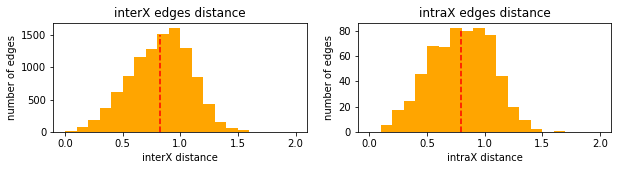

In [13]:
# Plot distribution of distance in selected edges
hic_threshold = 0.75
t = np.quantile(joint_interX_edge_list['scaled_hic'],hic_threshold)
u = np.quantile(joint_intraX_edge_list['scaled_hic'],hic_threshold)
inter_selected = joint_interX_edge_list[joint_interX_edge_list['scaled_hic']>t]
intra_selected = joint_intraX_edge_list[joint_intraX_edge_list['scaled_hic']>u]
[['source','target','hic','scaled_hic','distance']]
plt.figure(figsize=(10,2))
# interX
plt.subplot(1, 2, 1)
plt.hist(inter_selected['distance'], 
         bins=np.arange(0,2.1,0.1),
        color='orange')
plt.vlines(x=np.mean(inter_selected['distance']), ymin=0, ymax=1500, color='red', linestyle='dashed')
plt.xlabel('interX distance')
plt.ylabel('number of edges')
plt.title('interX edges distance')

# intraX
plt.subplot(1, 2, 2)
plt.hist(intra_selected['distance'], 
         bins=np.arange(0,2.1,0.1),
        color='orange')
plt.vlines(x=np.mean(intra_selected['distance']), ymin=0, ymax=80, color='red', linestyle='dashed')
plt.xlabel('intraX distance')
plt.ylabel('number of edges')
plt.title('intraX edges distance')

plt.show()

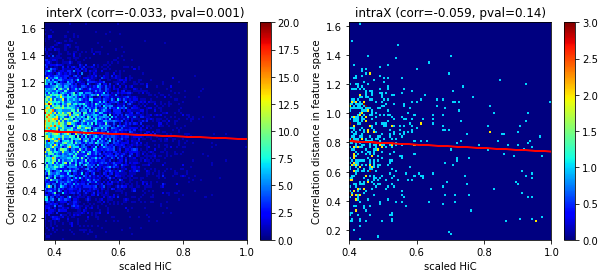

In [14]:
# Plot relationship between HiC and distance
hic_threshold = 0.75
t = np.quantile(joint_interX_edge_list['scaled_hic'],hic_threshold)
u = np.quantile(joint_intraX_edge_list['scaled_hic'],hic_threshold)
inter_selected = joint_interX_edge_list[joint_interX_edge_list['scaled_hic']>t]
intra_selected = joint_intraX_edge_list[joint_intraX_edge_list['scaled_hic']>u][['source','target','hic','scaled_hic','distance']]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# InterX edges
x = inter_selected['scaled_hic']
y = inter_selected['distance']
h1 = ax1.hist2d(x, y, (100, 100), cmap=plt.cm.jet)
m, b = np.polyfit(x, y, 1)
ax1.plot(x, m*x+b, color='red')
ax1.set_xlabel('scaled HiC')
ax1.set_ylabel('Correlation distance in feature space')
fig.colorbar(h1[3], ax=ax1)
pearson = ss.pearsonr(x,y)
ax1.set_title('interX (corr='+str(np.round(pearson[0],3))+', pval='+str(np.round(pearson[1],3))+')')
# IntraX edges
x = intra_selected['scaled_hic']
y = intra_selected['distance']
h2 = ax2.hist2d(x, y, (100, 100), cmap=plt.cm.jet)
m, b = np.polyfit(x, y, 1)
ax2.plot(x, m*x+b, color='red')
ax2.set_xlabel('scaled HiC')
ax2.set_ylabel('Correlation distance in feature space')
fig.colorbar(h2[3], ax=ax2)
pearson = ss.pearsonr(x,y)
ax2.set_title('intraX (corr='+str(np.round(pearson[0],3))+', pval='+str(np.round(pearson[1],3))+')')
plt.show()

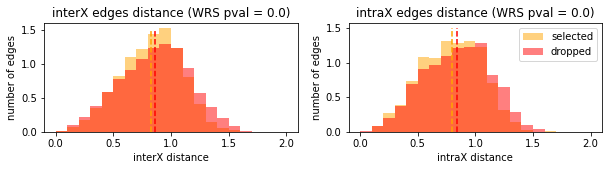

In [15]:
# Compare distribution of distances for edges that were dropped and edges that were kept
hic_threshold = 0.75
t = np.quantile(joint_interX_edge_list['scaled_hic'],hic_threshold)
u = np.quantile(joint_intraX_edge_list['scaled_hic'],hic_threshold)
inter_selected = joint_interX_edge_list[joint_interX_edge_list['scaled_hic']>t]
intra_selected = joint_intraX_edge_list[joint_intraX_edge_list['scaled_hic']>u]
inter_dropped = joint_interX_edge_list[joint_interX_edge_list['scaled_hic']<=t]
intra_dropped = joint_intraX_edge_list[joint_intraX_edge_list['scaled_hic']<=u]
plt.figure(figsize=(10,2))
# interX
plt.subplot(1, 2, 1)
plt.hist(inter_selected['distance'], bins=np.arange(0,2.1,0.1), density=True,
         color='orange', alpha=0.5, label='selected')
plt.hist(inter_dropped['distance'], bins=np.arange(0,2.1,0.1), density=True,
         color='red', alpha=0.5, label='dropped')
plt.vlines(x=np.mean(inter_selected['distance']), ymin=0, ymax=1.5, color='orange', linestyle='dashed')
plt.vlines(x=np.mean(inter_dropped['distance']), ymin=0, ymax=1.5, color='red', linestyle='dashed')
plt.xlabel('interX distance')
plt.ylabel('number of edges')
wrs_pval = np.round(ss.ranksums(inter_selected['distance'], inter_dropped['distance'])[1],2)
plt.title('interX edges distance (WRS pval = '+str(wrs_pval)+')')

# intraX
plt.subplot(1, 2, 2)
plt.hist(intra_selected['distance'], bins=np.arange(0,2.1,0.1), density=True,
         color='orange', alpha=0.5, label='selected')
plt.hist(intra_dropped['distance'], bins=np.arange(0,2.1,0.1), density=True,
         color='red', alpha=0.5, label='dropped')
plt.vlines(x=np.mean(intra_selected['distance']), ymin=0, ymax=1.5, color='orange', linestyle='dashed')
plt.vlines(x=np.mean(intra_dropped['distance']), ymin=0, ymax=1.5, color='red', linestyle='dashed')
plt.xlabel('intraX distance')
plt.ylabel('number of edges')
wrs_pval = np.round(ss.ranksums(intra_selected['distance'], intra_dropped['distance'])[1],2)
plt.title('intraX edges distance (WRS pval = '+str(wrs_pval)+')')
plt.legend(loc='upper right')
plt.show()

# HC clustering analysis

In [16]:
# Import initial clustering
initial_cliqueG = pickle.load(open(saving_dir+'initial_cliqueG.pkl', 'rb'))

In [17]:
# Parameters
hic_threshold = 0.75
with_intra = True
weights = 'distance'

In [18]:
# Selected edge list
t = np.quantile(joint_interX_edge_list['scaled_hic'],hic_threshold)
u = np.quantile(joint_intraX_edge_list['scaled_hic'],hic_threshold)
inter_selected = joint_interX_edge_list[joint_interX_edge_list['scaled_hic']>t]
intra_selected = joint_intraX_edge_list[joint_intraX_edge_list['scaled_hic']>u][['source','target','hic','scaled_hic','distance']]
adhesome_edge_list = inter_selected
if with_intra == True:
    adhesome_edge_list = pd.concat([adhesome_edge_list,intra_selected])
G = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic','distance'])
G.add_nodes_from(active_adhesome_genes)

In [22]:
# Perform HC with various thresholds
threshold_list = np.arange(0,2,0.01)
distance_with_init = []
for hc_threshold in tqdm(threshold_list):
    # Cluster
    clustering_graph2_hc = cc.hierarchical_clustering2(joint_interX_edge_list, 
                                                      joint_intraX_edge_list,
                                                      selected_genes,
                                                      hic_threshold,
                                                      with_intra,
                                                      weights,
                                                      hc_threshold,
                                                      hc_method='ward',
                                                      plot=False)
    # Create a clique graph corresponding to this clustering
    clique_edgelist = pd.DataFrame(columns=['source','target','weight'])
    for i in np.arange(len(selected_genes)):
        for j in np.arange(i+1, len(selected_genes)):
            if clustering_graph2_hc[i]==clustering_graph2_hc[j]:
                new_edge = pd.DataFrame({'source': [selected_genes[i]],
                                         'target': [selected_genes[j]],                
                                         'weight': [1]})
                clique_edgelist = clique_edgelist.append(new_edge)
    cliqueG = nx.Graph(nx.induced_subgraph(nx.from_pandas_edgelist(clique_edgelist, edge_attr=['weight']), 
                                          initial_cliqueG.nodes))
    # Distance with iniial clique graph
    dist = len(set(cliqueG.edges)-set(initial_cliqueG.edges)) + len(set(initial_cliqueG.edges)-set(cliqueG.edges))
    distance_with_init.append(dist)
distance_with_init = np.array(distance_with_init)

100%|██████████| 200/200 [01:09<00:00,  2.89it/s]


t_critic = 0.65


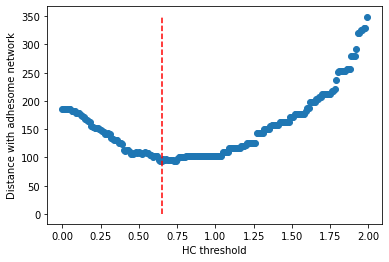

In [30]:
# Performance of different HC thresholds
t_critic= threshold_list[np.argmin(distance_with_init)]
print('t_critic = '+str(t_critic))
plt.figure()
plt.scatter(threshold_list, distance_with_init)
plt.xlabel('HC threshold')
plt.ylabel('Distance with adhesome network')
plt.vlines(x = t_critic, ymin =0, ymax=350, color='red', linestyle='dashed')
plt.show()

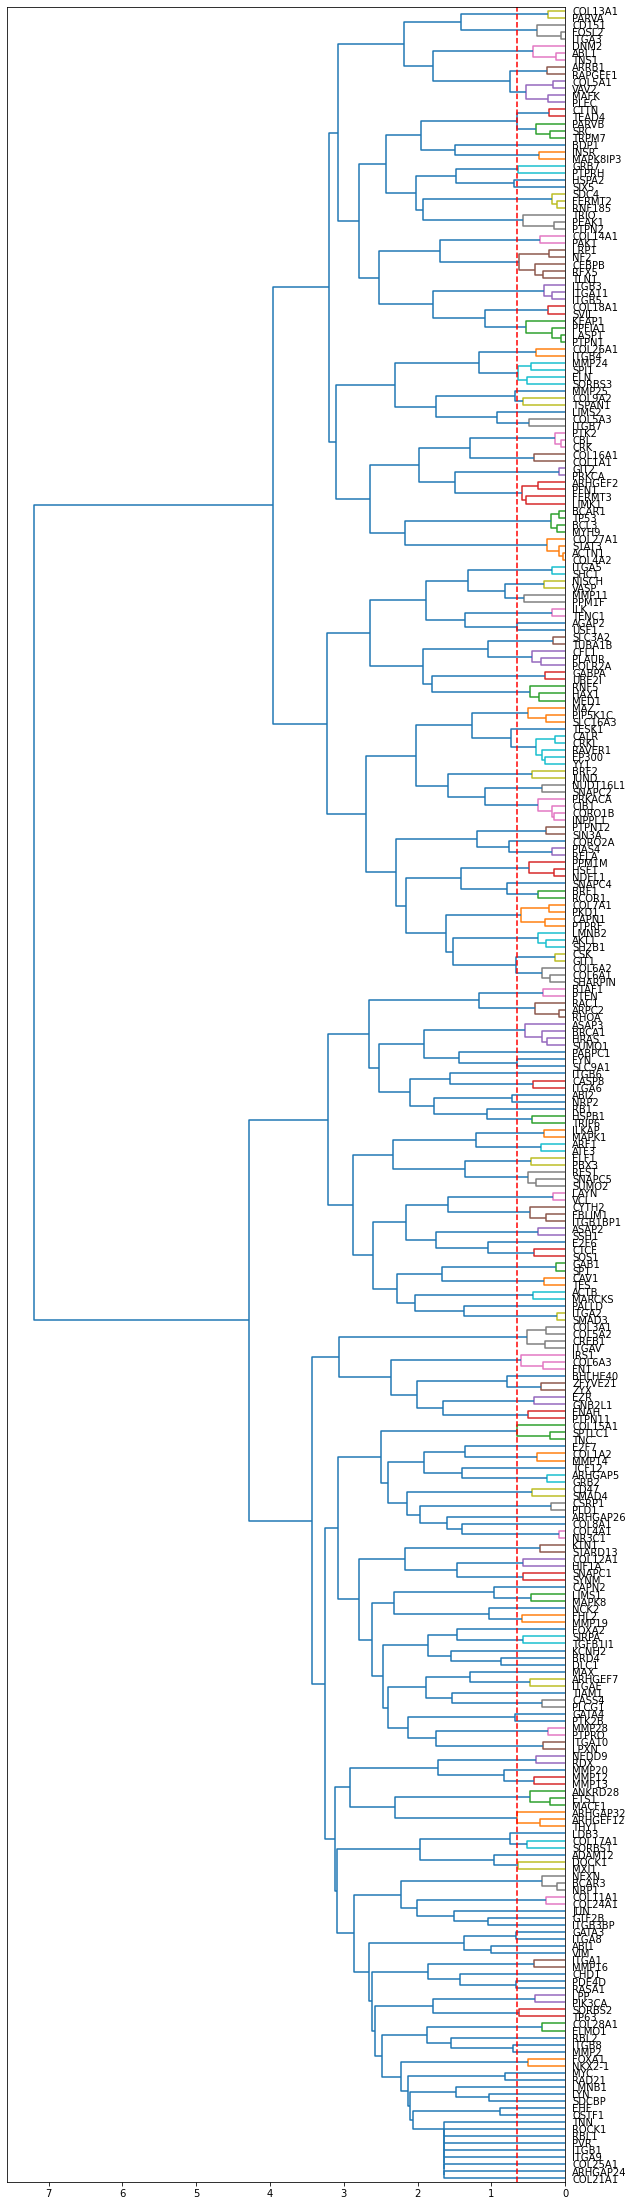

Number of clusters = 164
Number of singletons = 66
Number of nodes in non trivial clusters = 243
Size of clusters


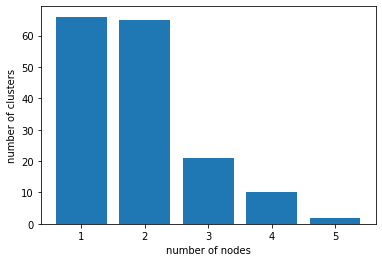

In [31]:
#Run HC
reload(cc)
hc_threshold = t_critic
clustering_graph2_hc = cc.hierarchical_clustering2(joint_interX_edge_list, 
                                                  joint_intraX_edge_list,
                                                  selected_genes,
                                                  hic_threshold,
                                                  with_intra,
                                                  weights,
                                                  hc_threshold,
                                                  hc_method='ward',
                                                  plot=True)
# Clustering characteristics
comps = np.unique(np.unique(clustering_graph2_hc, return_counts=True)[1],return_counts=True)
print('Number of clusters = '+str(len(np.unique(clustering_graph2_hc))))
print('Number of singletons = '+str(comps[1][0]))
print('Number of nodes in non trivial clusters = '+str(len(clustering_graph2_hc)-comps[1][0]))
print('Size of clusters')
plt.figure()
plt.bar(x=comps[0], height=comps[1])
plt.xlabel('number of nodes')
plt.ylabel('number of clusters')
plt.show()

In [32]:
# Clustered graph
cG = G.copy()
labels = np.array(sorted(cG.nodes))
n = len(labels)
# Add cluster information for each node
nx.set_node_attributes(cG, {labels[i]: str(clustering_graph2_hc[i]) for i in range(n)}, "hc_cluster")
# Add chromosome information for each node
nx.set_node_attributes(cG, {labels[i]: joint_chr_loci[joint_chr_loci['gene']==labels[i]]['chrom'].values[0] for i in range(n)}, "chromosome")
# Drop singletons
singleton_clusters = np.where(np.unique(clustering_graph2_hc, return_counts=True)[1]==1)[0]+1
singletons = labels[np.where([node_cluster in singleton_clusters for node_cluster in clustering_graph2_hc])]
cG.remove_nodes_from(singletons)
# Save network to html
#oi.output_networkx_graph_as_interactive_html(cG, filename=saving_dir+"clusteredG_hc_intra.html")
#oi.output_networkx_graph_as_interactive_html(cG, filename=saving_dir+"clusteredG_hc_nointra.html")

<Figure size 432x288 with 0 Axes>

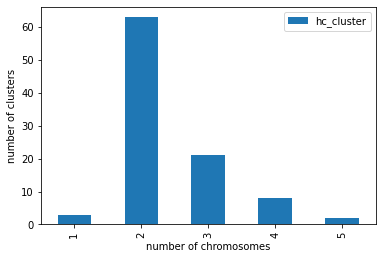

In [33]:
# Plot number of chromosomes per cluster
plt.figure()
oi.get_networkx_graph_as_dataframe_of_nodes(cG).groupby('hc_cluster')['chromosome'].nunique().reset_index().groupby('chromosome').count().plot.bar()
plt.xlabel('number of chromosomes')
plt.ylabel('number of clusters')
plt.show()

-----------------------------------------------------------------------------------------------------------------

# Cluster analysis

In [53]:
# Create dataframe with cluster
clusters_df = pd.DataFrame({'genes': selected_genes, 'cluster': clustering_graph2_hc})
clusters_df = clusters_df.groupby(['cluster']).agg({'genes':lambda x : list(x)}). reset_index()
clusters_df['chromosomes'] = [[gene2chrom[g] for g in clusters_df.iloc[i]['genes']]
                                    for i in range(clusters_df.shape[0])]
clusters_df['n_chromosomes'] = [len(np.unique(clusters_df.iloc[i]['chromosomes'])) for i in range(clusters_df.shape[0])]

In [54]:
# Annotate adhesome genes and TF genes
clusters_df['adhesome_genes'] = [[gene for gene in clusters_df.iloc[i]['genes'] 
                                        if gene in active_adhesome_genes]
                                      for i in range(clusters_df.shape[0])]
clusters_df['tf_genes'] = [[gene for gene in clusters_df.iloc[i]['genes'] 
                                        if gene in active_lung_adhesome_tf_genes]
                                      for i in range(clusters_df.shape[0])]
clusters_df['other_genes'] = [[gene for gene in clusters_df.iloc[i]['genes'] 
                                        if gene in other_genes]
                                      for i in range(clusters_df.shape[0])]

In [55]:
# Cluster size
clusters_df['size_genes'] = [len(clusters_df.iloc[i]['genes']) for i in range(clusters_df.shape[0])]
clusters_df['size_tf_genes'] = [len(clusters_df.iloc[i]['tf_genes']) for i in range(clusters_df.shape[0])]
clusters_df['size_other_genes'] = [len(clusters_df.iloc[i]['other_genes']) for i in range(clusters_df.shape[0])]
clusters_df = clusters_df.sort_values(by=['size_genes', 'size_tf_genes'], ascending=False)
# Only keep clusters with more than 2 genes
clusters_df = clusters_df[clusters_df['size_genes']>1]

In [56]:
# Specificity of TFs
clusters_df['prop_adhesome_targets'] =[[np.round(len(active_lung_tf2target[tf].intersection(set(active_adhesome_genes)))/len(active_adhesome_genes),3) for tf in clusters_df.iloc[i]['tf_genes']]
                                              for i in range(clusters_df.shape[0])]
clusters_df['prop_genome_targets'] =[[np.round(len(active_lung_tf2target[tf].intersection(set(all_active_genes)))/len(all_active_genes),3) for tf in clusters_df.iloc[i]['tf_genes']]
                                              for i in range(clusters_df.shape[0])]

In [63]:
# Print stats
print('Number of clusters = '+str(clusters_df.shape[0]))
print('Number of genes in clusters = '+str(len(np.unique(sorted(itertools.chain.from_iterable(clusters_df['genes']))))))
pickle.dump(clusters_df, open(saving_dir+'adhesome_clusters_df.pkl', 'wb'))
clusters_df[(clusters_df['size_tf_genes']>0) | (clusters_df['size_other_genes']>0)]

Number of clusters = 98
Number of genes in clusters = 243


,cluster,genes,chromosomes,n_chromosomes,adhesome_genes,tf_genes,other_genes,size_genes,size_tf_genes,size_other_genes,prop_adhesome_targets,prop_genome_targets
15,16,"[CEBPB, LRP1, NF2, RFX5, TLN1]","[chr20, chr12, chr22, chr1, chr9]",5,"[LRP1, NF2, TLN1]","[CEBPB, RFX5]",[],5,2,0,"[0.806, 0.01]","[0.319, 0.008]"
42,43,"[CALR, CRKL, EP300, RAVER1, YY1]","[chr19, chr22, chr22, chr19, chr14]",3,"[CALR, CRKL, RAVER1]","[EP300, YY1]",[],5,2,0,"[0.628, 0.133]","[0.231, 0.071]"
59,60,"[ASAP3, BRCA1, HRAS, SUMO1]","[chr1, chr17, chr11, chr2]",4,"[ASAP3, HRAS]","[BRCA1, SUMO1]",[],4,2,0,"[0.143, 0.01]","[0.052, 0.004]"
4,5,"[COL5A1, MAFK, PLEC, VAV2]","[chr9, chr7, chr8, chr9]",3,"[PLEC, VAV2]",[MAFK],[COL5A1],4,1,1,[0.077],[0.021]
20,21,"[ELN, MMP24, SORBS3, SPI1]","[chr7, chr20, chr8, chr11]",4,[SORBS3],[SPI1],"[ELN, MMP24]",4,1,2,[0.76],[0.313]
29,30,"[BCAR1, BCL3, MYH9, TP53]","[chr16, chr19, chr22, chr17]",4,"[BCAR1, MYH9]",[BCL3],[],4,1,0,[0.265],[0.071]
83,84,"[COL3A1, COL5A2, CREB1, ITGAV]","[chr2, chr2, chr2, chr2]",1,[ITGAV],[CREB1],"[COL3A1, COL5A2]",4,1,2,[0.27],[0.15]
30,31,"[ACTN1, COL27A1, COL4A2, STAT3]","[chr14, chr9, chr13, chr17]",4,"[ACTN1, STAT3]",[],"[COL27A1, COL4A2]",4,0,2,[],[]
53,54,"[CAPN1, COL7A1, PKD1, PTPRF]","[chr11, chr3, chr16, chr1]",4,"[CAPN1, PKD1, PTPRF]",[],[COL7A1],4,0,1,[],[]
72,73,"[REST, SNAPC5, SUMO2]","[chr4, chr15, chr17]",3,[],"[REST, SUMO2]",[],3,2,0,"[0.015, 0.168]","[0.009, 0.045]"


---------

# Build network of clusters

In [64]:
clusters_df = clusters_df[(clusters_df['size_tf_genes']>0) | (clusters_df['size_other_genes']>0)]

In [69]:
# Build network of clusters
edge_list = pd.DataFrame(columns=['source','target','source_id','target_id','weight','TFs'])
to_remove = []
for i in range(len(clusters_df)):
    for j in range(len(clusters_df)):
        # Cluster nodes
        cluster1 = format_node_label(clusters_df.iloc[i]['genes'])
        cluster2 = format_node_label(clusters_df.iloc[j]['genes'])
        # Clusters ID
        cluster1_id = clusters_df.iloc[i]['cluster']
        cluster2_id = clusters_df.iloc[j]['cluster']
        # Nodes in clusters
        cluster1_tfs = clusters_df.iloc[i]['tf_genes']
        cluster1_tfs = list(set(clusters_df.iloc[i]['tf_genes'])-set(to_remove))
        cluster1_tfs_spec = clusters_df.iloc[i]['prop_genome_targets']
        cluster2_nodes = clusters_df.iloc[j]['genes']
        # Normalized edge weight
        n_target_genes = len(cluster2_nodes)
        n_tf_genes = len(cluster1_tfs)
        if n_tf_genes>0: 
            tfs_involved_in_edge = [tf for tf in cluster1_tfs
                                    if len(active_lung_tf2target[tf].intersection(set(cluster2_nodes)))>0]
#             weight = np.sum(np.array([len(active_lung_tf2target[cluster1_tfs[i]].intersection(set(cluster2_nodes)))*(1-cluster1_tfs_spec[i])
#                                       for i in range(len(cluster1_tfs))]))/(n_target_genes*n_tf_genes)
            weight = np.sum(np.array([len(active_lung_tf2target[cluster1_tfs[i]].intersection(set(cluster2_nodes)))
                                     for i in range(len(cluster1_tfs))]))/(n_target_genes*n_tf_genes)
            # Create edge
            new_edge = pd.DataFrame({'source': [cluster1],
                                     'target': [cluster2],                
                                     'source_id': [cluster1_id],
                                     'target_id': [cluster2_id],
                                     'weight':[weight],
                                     'TFs': [','.join(tfs_involved_in_edge)]})
            edge_list = edge_list.append(new_edge)
edge_list = edge_list[edge_list['weight']>0]

In [85]:
# Create graph
G = nx.from_pandas_edgelist(edge_list, edge_attr=['weight','TFs'], create_using=nx.DiGraph)
# Add node metadata
n = len(G.nodes)+1
nx.set_node_attributes(G, 
        {format_node_label(clusters_df.iloc[i]['genes']): len(clusters_df.iloc[i]['adhesome_genes']) for i in range(n)}, 
                       "n_adhesome")
nx.set_node_attributes(G, 
        {format_node_label(clusters_df.iloc[i]['genes']): len(clusters_df.iloc[i]['tf_genes']) for i in range(n)}, 
                       "n_TFs")
nx.set_node_attributes(G, 
        {format_node_label(clusters_df.iloc[i]['genes']): len(clusters_df.iloc[i]['other_genes']) for i in range(n)}, 
                       "n_others")
nx.set_node_attributes(G, 
        {format_node_label(clusters_df.iloc[i]['genes']): clusters_df.iloc[i]['adhesome_genes'] for i in range(n)}, 
                       "all_adhesomes")
nx.set_node_attributes(G, 
        {format_node_label(clusters_df.iloc[i]['genes']): clusters_df.iloc[i]['tf_genes'] for i in range(n)}, 
                       "all_TFs")
nx.set_node_attributes(G, 
        {format_node_label(clusters_df.iloc[i]['genes']): clusters_df.iloc[i]['other_genes'] for i in range(n)}, 
                       "all_others")
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 52
Number of edges: 658
Average in degree:  12.6538
Average out degree:  12.6538


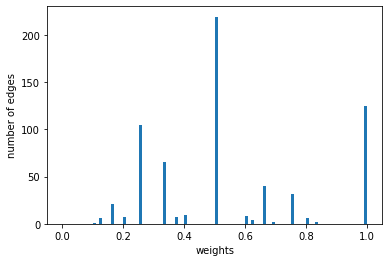

In [86]:
# Distribution of edge weights
plt.figure()
plt.hist(edge_list['weight'], bins=np.arange(0,1.01,0.01))
#plt.vlines(x=0.55, ymin=0, ymax=350, color='red', linestyle='dashed')
plt.xlabel('weights')
plt.ylabel('number of edges')
plt.show()

In [97]:
# Define network object
net  = Network(height="1000px",
               width="1000px",
               directed=True,
               font_color='black',
               notebook=True,
               layout=None,
               heading='Adhesome network')

# Set layout
net.hrepulsion(node_distance=200,
               central_gravity=0.0,
               spring_length=100,
               spring_strength=0.01,
               damping=0.09)

# Import NetworkX graph
from_nx(G, net, default_node_size=20, 
        default_edge_weight=1,edge_weight_scale=0.1, edge_color_scale=1, edge_threshold=0.6, 
        hidden_edges= to_remove,
        shape='box')
#net.show_buttons()
net.show("adhesome_network.html")

In [115]:
# Self reinforcing edges
self_edge_list = edge_list[edge_list['source']==edge_list['target']]
# Create graph
Gself = nx.from_pandas_edgelist(self_edge_list, edge_attr=['weight','TFs'], create_using=nx.DiGraph)
# Add node metadata
n = len(G.nodes)
nx.set_node_attributes(Gself, 
        {format_node_label(clusters_df.iloc[i]['genes']): len(clusters_df.iloc[i]['adhesome_genes']) for i in range(n)}, 
                       "n_adhesome")
nx.set_node_attributes(Gself, 
        {format_node_label(clusters_df.iloc[i]['genes']): len(clusters_df.iloc[i]['tf_genes']) for i in range(n)}, 
                       "n_TFs")
nx.set_node_attributes(Gself, 
        {format_node_label(clusters_df.iloc[i]['genes']): clusters_df.iloc[i]['adhesome_genes'] for i in range(n)}, 
                       "all_adhesomes")
nx.set_node_attributes(Gself, 
        {format_node_label(clusters_df.iloc[i]['genes']): clusters_df.iloc[i]['tf_genes'] for i in range(n)}, 
                       "all_TFs")
print(nx.info(Gself))

Name: 
Type: DiGraph
Number of nodes: 18
Number of edges: 18
Average in degree:   1.0000
Average out degree:   1.0000


In [119]:
# Define network object
net  = Network(height="1000px",
               width="1000px",
               directed=True,
               font_color='black',
               notebook=True,
               layout=None,
               heading='Adhesome network')

# Set layout
net.hrepulsion(node_distance=200,
               central_gravity=0.0,
               spring_length=100,
               spring_strength=0.01,
               damping=0.09)

# Import NetworkX graph
from_nx(Gself, net, default_node_size=20, 
        default_edge_weight=1,edge_weight_scale=0.1, edge_color_scale=1, edge_threshold=0, 
        hidden_edges=[],
        shape='box')
#net.show_buttons()
net.show("self_adhesome_network.html")

In [106]:
oi.get_networkx_graph_as_dataframe_of_nodes(Gself)

,n_adhesome,n_TFs,all_adhesomes,all_TFs
CALR CRKL \n EP300 RAVER1 \n YY1,3,2,"[CALR, CRKL, RAVER1]","[EP300, YY1]"
CEBPB LRP1 \n NF2 RFX5 \n TLN1,3,2,"[LRP1, NF2, TLN1]","[CEBPB, RFX5]"
CD151 FOSL2 \n ITGA3 JUND,2,2,"[CD151, ITGA3]","[FOSL2, JUND]"
MAZ PIP5K1C \n SLC16A3,2,1,"[PIP5K1C, SLC16A3]",[MAZ]
BCAR1 BCL3 \n MYH9,2,1,"[BCAR1, MYH9]",[BCL3]
CFL1 PLAUR \n POLR2A,2,1,"[CFL1, PLAUR]",[POLR2A]
ANKRD28 ETS1 \n MACF1,2,1,"[ANKRD28, MACF1]",[ETS1]
SIRPA TEAD4 \n TGFB1I1,2,1,"[SIRPA, TGFB1I1]",[TEAD4]


# Helper functions

In [66]:
def format_node_label(raw_label):
    '''
    Function to put node label in a square format
    Args:
        raw_label: (Numpy array) array of gene names
    Returns:
        The formatted label (a string)
    '''
    label = raw_label.copy()   
    # Line breaks
    for i in range(1, len(labels)//2+1):
        if 2*i<len(label):
            label[2*i-1] = label[2*i-1]+' \n '
    label = ' '.join(label)
    return label

In [67]:
def from_nx(graph, pyvisnet, default_node_size=1, 
            default_edge_weight=1, edge_weight_scale=1, edge_color_scale=1, edge_threshold=0, hidden_edges=[], 
            shape='circle'):
    """
    This method takes an exisitng Networkx graph and translates
    it to a PyVis graph format that can be accepted by the VisJs
    API in the Jinja2 template. This operation is done in place.
    """
    nx_graph = graph.copy()
    assert(isinstance(nx_graph, nx.Graph))
    edges = nx_graph.edges(data=True)
    nodes = nx_graph.nodes(data=True)

    if len(edges) > 0:
        for e in edges:
            # Specify node size
            if 'size' not in nodes[e[0]].keys():
                nodes[e[0]]['size'] = default_node_size
            nodes[e[0]]['size'] = int(nodes[e[0]]['size'])
            if 'size' not in nodes[e[1]].keys():
                nodes[e[1]]['size'] = default_node_size
            nodes[e[1]]['size'] = int(nodes[e[1]]['size'])
            # Specify node color
            if nodes[e[0]]['n_TFs']>0:
                nodes[e[0]]['color'] = 'lightcoral'
            else:
                nodes[e[0]]['color'] = 'dodgerblue'
            if nodes[e[1]]['n_TFs']>0:
                nodes[e[1]]['color'] = 'lightcoral'
            else:
                nodes[e[1]]['color'] = 'dodgerblue'
            # Specify node title
            if len(nodes[e[0]]['all_TFs'])>0:
                nodes[e[0]]['title'] = 'adhesome: '+','.join(nodes[e[0]]['all_adhesomes'])+' / '+'TFs: '+','.join(nodes[e[0]]['all_TFs'])
            else:
                nodes[e[0]]['title'] = 'adhesome: '+','.join(nodes[e[0]]['all_adhesomes'])+' / '+'no TF'
            if nodes[e[1]]['n_TFs']>0:
                nodes[e[1]]['title'] = 'adhesome: '+','.join(nodes[e[1]]['all_adhesomes'])+' / '+'TFs: '+','.join(nodes[e[1]]['all_TFs'])
            else:
                nodes[e[1]]['title'] = 'adhesome: '+','.join(nodes[e[1]]['all_adhesomes'])+' / '+'no TF'
            pyvisnet.add_node(e[0], **nodes[e[0]], shape=shape)
            pyvisnet.add_node(e[1], **nodes[e[1]], shape=shape)

            if 'weight' not in e[2].keys():
                e[2]['weight'] = default_edge_weight
            edge_dict = e[2].copy()
            edge_dict["value"] = e[2]['weight']*edge_weight_scale
            edge_dict["title"] = 'TF: '+e[2]['TFs']+'\n'+'val: '+str(e[2]['weight'])
            edge_dict["color"] = colfunc(e[2]['weight']*edge_color_scale)
            edge_dict["arrowStrikethrough"] = False
            if (e[2]['weight']>edge_threshold) and (e[2]['TFs'] not in hidden_edges):
                pyvisnet.add_edge(e[0], e[1], **edge_dict)

    for node in nx.isolates(nx_graph):
        if 'size' not in nodes[node].keys():
            nodes[node]['size']=default_node_size
        pyvisnet.add_node(node, **nodes[node], shape=shape)

In [68]:
def colfunc(val, minval=0, maxval=1):
    """ Convert value in the range minval...maxval to a color in the range
        startcolor to stopcolor. The colors passed and the one returned are
        composed of a sequence of N component values (e.g. RGB).
    """
    RED, YELLOW, GREEN  = (1, 0, 0), (1, 1, 0), (0, 1, 0)
    CYAN, BLUE, MAGENTA = (0, 1, 1), (0, 0, 1), (1, 0, 1)
    WHITE = (1, 1, 1)
    f = float(val-minval) / (maxval-minval)
    return mpl.colors.rgb2hex(tuple(f*(b-a)+a for (a, b) in zip(WHITE, RED)))

# Specificity of adhesome TFs

In [89]:
# How specific are adhesome TFs
dir_htftarget = '/home/louiscam/projects/gpcr/data/tf_data/hTFtarget/'
htargettf_df = pd.read_csv(dir_htftarget+'hTFtarget.txt', sep='\t', header=0)
htargettf_df.columns = ['geneSymbol', 'target', 'tissue']
htargettf_lung_df = htargettf_df[htargettf_df['tissue'].str.contains('lung')]
htargettf_lung_df_adhesome = htargettf_lung_df[htargettf_lung_df['geneSymbol'].isin(active_lung_adhesome_tf_genes) &
                                               htargettf_lung_df['target'].isin(active_adhesome_genes)]

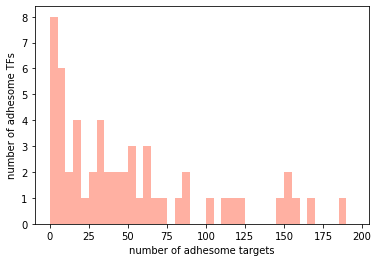

In [90]:
# Histogram of number of adhesome targets
plt.figure()
plt.hist(htargettf_lung_df_adhesome.groupby(['geneSymbol'])['target'].nunique(), 
         bins=np.arange(0,200,5), color='tomato', alpha=0.5, label='adhesome TFs')
plt.xlabel('number of adhesome targets')
plt.ylabel('number of adhesome TFs')
#plt.legend(loc='upper right')
plt.show()

In [91]:
# Specificity dataframe
spec_tf = htargettf_lung_df_adhesome.groupby(['geneSymbol'])['target'].nunique().reset_index()
spec_tf['pct_target'] = spec_tf['target']/len(active_adhesome_genes)
spec_tf = spec_tf.sort_values('target', ascending=False)
spec_tf

,geneSymbol,target,pct_target
28,MAZ,189,0.964286
8,CTCF,166,0.846939
5,CEBPB,158,0.806122
25,LMNB1,153,0.780612
17,FOXA2,153,0.780612
47,SPI1,149,0.760204
13,EP300,123,0.627551
4,BRD4,117,0.596939
16,FOXA1,114,0.581633
27,MAX,102,0.520408


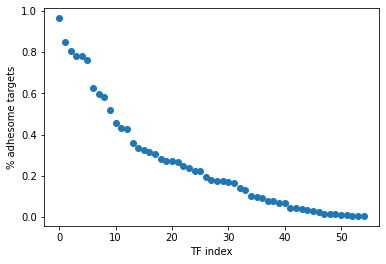

In [92]:
# Percentage of adhesome targets for adhesome TFs
plt.figure()
plt.scatter(range(len(spec_tf)),spec_tf['pct_target'])
plt.xlabel('TF index')
plt.ylabel('% adhesome targets')
plt.show()

In [93]:
# TFs to remove
to_remove = spec_tf[spec_tf['pct_target']>0.4]['geneSymbol'].values
to_remove

array(['MAZ', 'CTCF', 'CEBPB', 'LMNB1', 'FOXA2', 'SPI1', 'EP300', 'BRD4',
       'FOXA1', 'MAX', 'GABPA', 'ETS1', 'E2F6'], dtype=object)